In [12]:
import graph_tool.all as gt
import logging
import pickle
import os
import sys
from argparse import Namespace
import networkx as nx

from evaluation.stats import eval_torch_batch, adjs_to_graphs, eval_graph_list, eval_acc_sbm_graph
from easydict import EasyDict as edict
import numpy as np
import torch

from evaluation.stats import eval_torch_batch, adjs_to_graphs, eval_graph_list
from utils.arg_helper import mkdir, set_seed, load_data, graphs_to_tensor, load_model, parse_arguments, \
    get_config
from utils.graph_utils import discretenoise, generate_mask, discretenoise_balanced_single, discretenoise_balanced, discretenoise_single_density, discretenoise_balanced_single_density
from utils.loading_utils import get_mc_sampler, eval_sample_batch, prepare_test_model_train
from utils.visual_utils import plot_graphs_list, plot_inter_graphs, plot_inter_graphs_list, plot_inter_graphs_j

from easydict import EasyDict as edict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from evaluation.stats import eval_torch_batch

from model.langevin_mc import LangevinMCSampler

from utils.arg_helper import edict2dict, parse_arguments, get_config, process_config, set_seed_and_logger, load_data
from utils.graph_utils import gen_list_of_data_single, generate_mask
from utils.loading_utils import get_mc_sampler, get_score_model, eval_sample_batch
from utils.visual_utils import plot_graphs_adj
from model.ppgn import Powerful
from matplotlib import pyplot as plt
import wandb
import time

In [5]:
sysout=sys.stdout

def blockPrint():
    sys.stdout = open(os.devnull, 'w')

def enablePrint():
    sys.stdout = sysout

In [8]:
##function for printing the intermediate noiselevels to jupyter

def plot_inter_graphs_jup(graphs,flags,title,save_dir,nr_to_analyze=0):
    maxnodes=0
    graphs_proces=[]
    for g in graphs:
        graphs_proces.append(nx.from_numpy_matrix(g[0]))

    torch.set_printoptions(profile="full")
    figure = plt.figure(figsize=(25, 25))
    max_num=len(graphs)
    img_c = int(np.sqrt(max_num))
    pos=nx.spring_layout(graphs_proces[-1])
    for i, sigmalevel_adjs in enumerate(graphs_proces):
        plt.figure(figsize=(25, 25))
        nodes=flags.sum(-1)
        G = sigmalevel_adjs.copy()
        G.remove_nodes_from(list(nx.isolates(G)))
        e = G.number_of_edges()
        v = G.number_of_nodes()
        l = nx.number_of_selfloops(G)
        ax = plt.subplot(img_c+1, img_c+1, i+1)
        title_str = f'fl={"nrofnodes"},no={i}'
        nx.draw(G, pos, with_labels=False, **options)
        ax.title.set_text(title_str)
        plt.show()
        
    title=f'{title}-{nr_to_analyze}.pdf'
    figure.suptitle(title)

options = {
    'node_size': 2,
    'edge_color': 'black',
    'linewidths': 1,
    'width': 0.5
}

In [23]:
def sample_ppgn_simple(config,modellink,noise_num):
    
    device=sys.stdout
    blockPrint()
    
    train_graph_list, test_graph_list = load_data(config, get_graph_list=True)
    models = prepare_test_model_train(config,modellink)
    max_node_number = config.dataset.max_node_num
    test_batch_size = config.test.batch_size
    test_batch_size = 1
    
    
    def gen_init_data(batch_size):
        rand_idx = np.random.randint(0, len(train_graph_list), batch_size)
        graph_list = [train_graph_list[i] for i in rand_idx]
        base_adjs, base_x = graphs_to_tensor(config, graph_list)
        base_adjs, base_x = base_adjs.to(config.dev), base_x.to(config.dev)
        node_flags = base_adjs.sum(-1).gt(1e-5).to(dtype=torch.float32)

        ##create a matrix with p=1/2 elements at all positions Aij where i and j not masked by node_flagij=0:
        bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(config.dev)
        for k, matrix in enumerate(base_adjs):
            for i,row in enumerate(matrix):
                    for j,col in enumerate(row):
                        if 1/2 < node_flags[k][i] and 1/2 < node_flags[k][j]:
                            bernoulli_adj[k,i,j] = 1/2
                        
        noise_upper = torch.bernoulli(bernoulli_adj).triu(diagonal=1)
        noise_lower = noise_upper.transpose(-1, -2)
        initialmatrix = noise_lower + noise_upper
        return initialmatrix, base_x, node_flags
        ##returns initialmatrix = tensor of size batchsize x N x N

    file, sigma_list, model_params = models[0]
    model = load_model(*model_params)
    sigma_tens = torch.linspace(0,1/2,noise_num)
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()

    def add_bernoulli(flags, init_adjs, noiselevel):
        init_adjs, noise_added = discretenoise(init_adjs, flags, noiselevel, config)
        return init_adjs


    def take_step(noise_func, flags, init_adjs, noiselevel):
        init_adjs = add_bernoulli(flags, init_adjs, noiselevel)
        
        mask=generate_mask(flags).to(config.dev)
        noise_unnormal = noise_func(A=init_adjs.to(config.dev),feat=None,mask=mask.to(config.dev),noise=noiselevel)
        noise_unnormal = noise_unnormal.squeeze(-1)
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel+noise_rel.transpose(-1,-2))/2
        noise=torch.bernoulli(noise_rel)*mask
        
        inter_adjs = torch.where(noise>1/2,init_adjs-1,init_adjs)
        new_adjs = torch.where(inter_adjs < -1/2 , inter_adjs+2 , inter_adjs)
        
        return init_adjs,new_adjs


    def run_sample(eval_len=10, methods=None):
        gen_graph_list = []
        with torch.no_grad():
            while len(gen_graph_list)<eval_len:
                count=0
                init_adjs, init_x, flags = gen_init_data(batch_size = test_batch_size)

                ##
                mult_stages_noise = []
                mult_stages = [init_adjs.detach().cpu().numpy()]
                mult_stages_flags = flags[-test_batch_size*(0+1): len(flags)-(test_batch_size*(0))]
                ##

                while count<len(sigma_list):
                    noiselevel=sigma_list[len(sigma_list)-count-1]
                    noisy_adjs,init_adjs=take_step(lambda feat, A, mask, noise: model(feat, A, mask, noise), flags=flags, init_adjs=init_adjs, noiselevel=noiselevel)
                    count=count+1
                    mult_stages_noise.append(noisy_adjs.detach().cpu().numpy())
                    mult_stages.append(init_adjs.detach().cpu().numpy())
                    mult_stages_flags = torch.cat((mult_stages_flags, flags[-test_batch_size*(count): len(flags)-(test_batch_size*(count-1))]),0)
                gen_graph_list.extend(adjs_to_graphs(init_adjs.detach().cpu().numpy()))
        enablePrint()
        pic_title = f'{file.split("/")[-1]}_final_sample_ipynb_{noise_num}.pdf'
        #plot_graphs_list(graphs=gen_graph_list, title=pic_title, save_dir=config.save_dir)
        plot_inter_graphs_jup(graphs=mult_stages, flags=mult_stages_flags, title='intermediate', save_dir=config.save_dir, nr_to_analyze=0)
        plot_inter_graphs_jup(graphs=mult_stages_noise, flags=mult_stages_flags, title='intermediate', save_dir=config.save_dir, nr_to_analyze=0)
        result_dict = eval_graph_list(test_graph_list, gen_graph_list, methods=methods)
        return result_dict, gen_graph_list

    result_dict, gen_graph_list = run_sample(eval_len=32)
    return result_dict



In [22]:
## all functions here used for sampling the ppgn vlb loss implementation

def posterior(sigmatilde_t,sigma_t,sigmatilde_t1,x0,xt):
    if xt<0.01 and x0<0.01:
        return sigmatilde_t1 * sigma_t / (1-sigmatilde_t)
    elif xt>0.99 and x0<0.01:
        return sigmatilde_t1 * (1-sigma_t) / (sigmatilde_t)
    elif xt>0.99 and x0>0.99:
        return (1-sigmatilde_t1) * (1-sigma_t) / (1-sigmatilde_t)
    if xt<0.01 and x0>0.99:
        return (1-sigmatilde_t1) * sigma_t / (sigmatilde_t)

def sigma_lin_false(sigma_list):
    sigmas=[]
    for g,sigma in enumerate(sigma_list):
        if i<0.0000000001:
            sigmas.append(0.0)
        summ=0.0
        for k,sigpast in enumerate(sigmas):
            prod=1.0
            for j in range(0,g-1-k):
                prod = prod * ( 1 - 2 * sigmas[g-k] )
            prod = prod * sigmas[k]
        summ+=prod
        s=sigma-summ
        sigmas.append(s)

def sigma_lin(sigma_list):
    sigmas=[]
    for g,sigma in enumerate(sigma_list):
        if sigma<0.0000000001:
            sigmas.append(0.0)
            continue
        sigmas.append(((1-sigma)-(1-sigma_list[g-1]))/(1-2*(1-sigma_list[g-1])))
    return sigmas

def sample_ppgn_vlb(config,modellink,noise_num):
    start_time = time.time()
    device=sys.stdout
    blockPrint()
    train_graph_list, test_graph_list = load_data(config, get_graph_list=True)
    models = prepare_test_model_train(config,modellink)
    max_node_number = config.dataset.max_node_num
    test_batch_size = config.test.batch_size
    test_batch_size = 1
    
    def gen_init_data(batch_size):
        rand_idx = np.random.randint(0, len(train_graph_list), batch_size)
        graph_list = [train_graph_list[i] for i in rand_idx]
        base_adjs, base_x = graphs_to_tensor(config, graph_list)
        base_adjs, base_x = base_adjs.to(config.dev), base_x.to(config.dev)
        node_flags = base_adjs.sum(-1).gt(1e-5).to(dtype=torch.float32)

        ##create a matrix with p=1/2 elements at all positions Aij where i and j not masked by node_flagij=0:
        bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(config.dev)
        for k, matrix in enumerate(base_adjs):
            for i,row in enumerate(matrix):
                    for j,col in enumerate(row):
                        if 1/2 < node_flags[k][i] and 1/2 < node_flags[k][j]:
                            bernoulli_adj[k,i,j] = 1/2
        
        noise_upper = torch.bernoulli(bernoulli_adj).triu(diagonal=1)
        noise_lower = noise_upper.transpose(-1, -2)
        initialmatrix = noise_lower + noise_upper
        return initialmatrix, base_x, node_flags
        ##returns initialmatrix = tensor of size batchsize x N x N

    file, sigma_list, model_params = models[0]
    model = load_model(*model_params)
    sigma_tens = torch.linspace(0,1/2,noise_num+1)
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()
    sigma_list_nontilde=sigma_lin(sigma_list)

    def add_bernoulli(flags, init_adjs, noiselevel):
        init_adjs, noise_added = discretenoise(init_adjs, flags, noiselevel, config)
        return init_adjs

    def take_step(noise_func, flags, init_adjs, noiselevel,noiselevel_nontilde):
        mask=generate_mask(flags).to(config.dev)
        init_adjs = init_adjs * mask
        noise_unnormal = noise_func(A=init_adjs.to(config.dev),feat=None,mask=mask.to(config.dev),noise=noiselevel).to(config.dev)
        noise_unnormal = noise_unnormal.squeeze(-1)
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel+torch.transpose(noise_rel,-2,-1))/2
        ##here now noise_rel = p(xo_switched | xt)
        
        sigmatilde_t=noiselevel
        sigma_t=noiselevel_nontilde
        sigmatilde_t1=sigmatilde_t-sigmatilde_t/sigma_list.index(sigmatilde_t)
        score_i=torch.where(init_adjs>1/2,1-noise_rel,noise_rel)
        
        ##now calculate posterior(sigmatilde_t,sigma_t,sigmatilde_t1,0,xt)
        mult1=torch.where(init_adjs>1/2,(1-sigma_t),sigma_t)
        mult2=torch.where(torch.zeros_like(init_adjs)>1/2,1-sigmatilde_t1,sigmatilde_t1)
        xor=torch.logical_xor(init_adjs, torch.zeros_like(init_adjs))
        div=torch.where(xor>1/2,sigmatilde_t,1-sigmatilde_t)
        p = ( 1 - score_i ) * mult1*mult2/div

        ##now calculate posterior(sigmatilde_t,sigma_t,sigmatilde_t1,1,xt)
        mult1=torch.where(init_adjs>1/2,(1-sigma_t),sigma_t)
        mult2=torch.where(torch.ones_like(init_adjs)>1/2,1-sigmatilde_t1,sigmatilde_t1)
        xor=torch.logical_xor(init_adjs, torch.ones_like(init_adjs))
        div=torch.where(xor>1/2,sigmatilde_t,1-sigmatilde_t)
        p += ( score_i ) * mult1 * mult2/div

        ##p stands now for probablity p(x0=1|xt=xt)
        init_adjs = (p + p.transpose(-2,-1))/2

        ##now mask and sample from that and then make symmetrical, results in sample of x_0 given x_t
        init_adjs = init_adjs * mask
        init_adjs = torch.bernoulli(init_adjs).to(config.dev)
        new_adjs=init_adjs
        new_adjs = torch.triu(init_adjs,diagonal=1) + torch.triu(init_adjs,diagonal=1).transpose(-2,-1)
        
        return new_adjs


    def run_sample(eval_len=10, methods=None):
        gen_graph_list = []
        with torch.no_grad():
            while len(gen_graph_list)<eval_len:
                count=0
                init_adjs, init_x, flags = gen_init_data(batch_size = test_batch_size)

                ###
                mult_stages_noise = []
                mult_stages = [init_adjs.detach().cpu().numpy()]
                mult_stages_flags = flags[-test_batch_size*(0+1): len(flags)-(test_batch_size*(0))]
                ###

                while count<len(sigma_list)-1:
                    noiselevel=sigma_list[len(sigma_list)-count-1]
                    noiselevel_nontilde=sigma_list_nontilde[len(sigma_list)-count-1]
                    init_adjs=take_step(lambda feat, A, mask, noise: model(feat, A, mask, noise), flags=flags, init_adjs=init_adjs, noiselevel=noiselevel,noiselevel_nontilde=noiselevel_nontilde)
                    count=count+1
                    
                    mult_stages_noise.append(noisy_adjs.detach().cpu().numpy())
                    mult_stages.append(init_adjs.detach().cpu().numpy())
                    mult_stages_flags = torch.cat((mult_stages_flags, flags[-test_batch_size*(count): len(flags)-(test_batch_size*(count-1))]),0)
                
                gen_graph_list.extend(adjs_to_graphs(init_adjs.detach().cpu().numpy()))
        enablePrint()
        print(time.time()-start_time)
        pic_title = f'{file.split("/")[-1]}_final_sample_ipynb_{noise_num}.pdf'
        #plot_graphs_list(graphs=gen_graph_list, title=pic_title, save_dir=config.save_dir)
        plot_inter_graphs_jup(graphs=mult_stages, flags=mult_stages_flags, title='intermediate', save_dir=config.save_dir, nr_to_analyze=0)
        result_dict = eval_graph_list(test_graph_list, gen_graph_list, methods=methods)
        if "sbm" in config.dataset.name:
            likelyhood = eval_acc_sbm_graph(gen_graph_list, p_intra=0.85, p_inter=0.046875,strict=False,is_parallel=False)
            result_dict["likelyhood"]=likelyhood
        return result_dict, gen_graph_list, result_dict_2
    
    result_dict, gen_graph_list, result_dict_2 = run_sample(eval_len=32)
    return result_dict, result_dict_2

{0: array([-0.05087898, -0.48853811]), 1: array([-0.04337122, -0.35888638]), 2: array([ 0.0617647 , -0.42958669]), 3: array([ 0.17983786, -0.38391904]), 4: array([ 0.16167743, -0.51308561]), 5: array([ 0.05183101, -0.56399926]), 6: array([ 0.07687248, -0.30835172]), 7: array([0.60626332, 0.74504636]), 8: array([0.28615175, 0.96786072]), 9: array([ 0.71480677, -0.49611228]), 10: array([-0.09197246,  0.92399386]), 11: array([-0.38839308,  0.92536859]), 12: array([-1.        ,  0.04639278]), 13: array([-0.82156366,  0.58787274]), 14: array([0.91048781, 0.4816537 ]), 15: array([-0.92747436, -0.46811282]), 16: array([-0.5717082 , -0.79249809]), 17: array([0.8456688 , 0.12490126])}
[0, 1, 2, 3, 4, 5, 6]


<Figure size 1800x1800 with 0 Axes>

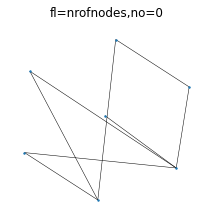

[0, 1, 2, 3, 4, 5, 6]


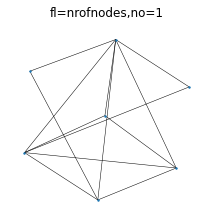

[0, 1, 2, 3, 4, 5, 6]


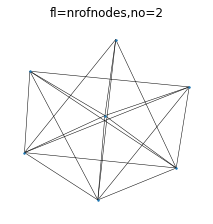

[0, 1, 2, 3, 4, 5, 6]


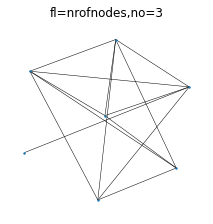

[0, 1, 2, 3, 4, 5, 6]


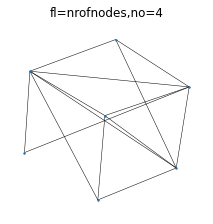

[0, 1, 2, 3, 4, 5, 6]


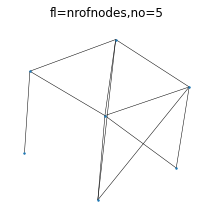

[0, 1, 2, 4, 5, 6]


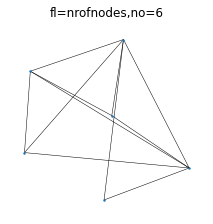

[0, 1, 2, 3, 4, 5, 6]


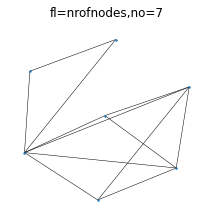

[0, 1, 2, 3, 4, 5, 6]


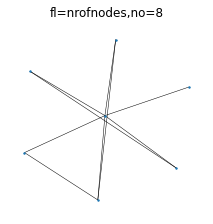

[0, 1, 2, 3, 4, 5, 6]


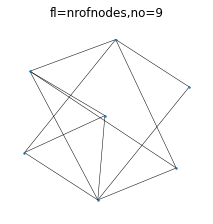

[0, 1, 2, 3, 4, 5, 6]


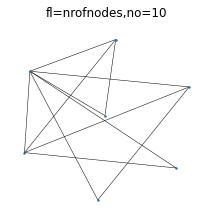

[0, 1, 2, 3, 4, 5, 6]


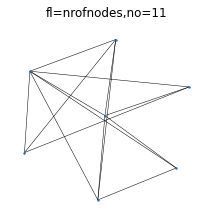

[0, 1, 2, 3, 4, 5, 6]


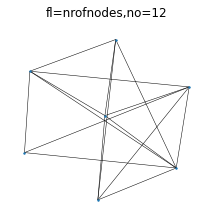

[0, 1, 2, 3, 4, 5, 6]


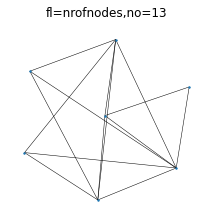

[0, 1, 2, 3, 4, 5, 6]


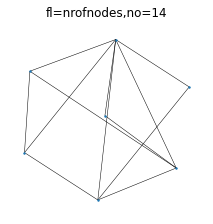

[0, 1, 2, 3, 4, 5, 6]


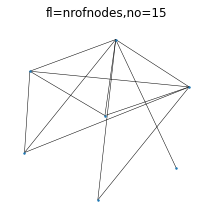

[0, 1, 2, 3, 4, 5, 6]


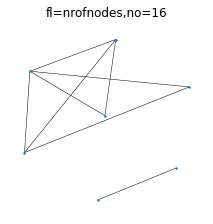

[0, 1, 2, 3, 4, 5, 6]


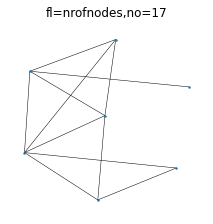

[0, 1, 2, 3, 4, 5, 6]


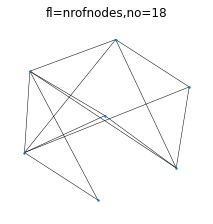

[0, 1, 2, 3, 4, 5, 6]


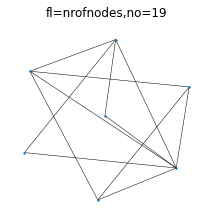

[0, 1, 2, 3, 4, 5, 6]


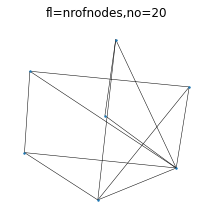

[0, 1, 2, 3, 4, 5, 6]


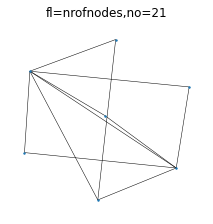

[0, 1, 2, 3, 4, 5, 6]


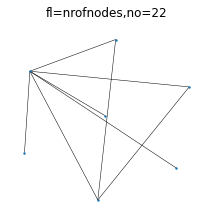

[0, 1, 2, 3, 4, 5, 6]


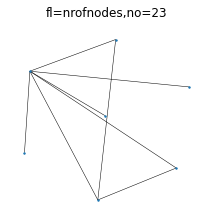

[0, 1, 2, 3, 4, 5, 6]


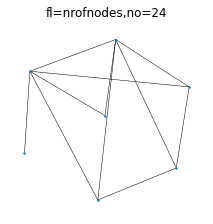

[0, 1, 2, 3, 4, 5, 6]


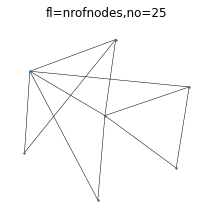

[0, 1, 2, 3, 4, 5, 6]


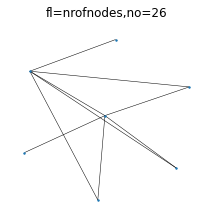

[0, 1, 2, 3, 4, 5, 6]


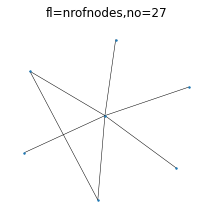

[0, 1, 2, 3, 4, 5, 6]


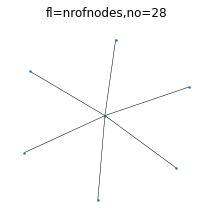

[0, 1, 2, 3, 4, 5, 6]


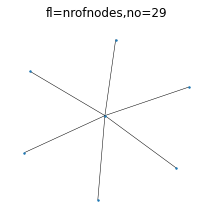

[0, 1, 2, 3, 4, 5, 6]


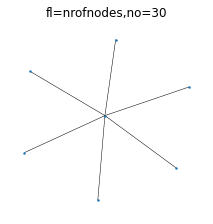

[0, 1, 2, 3, 4, 5, 6]


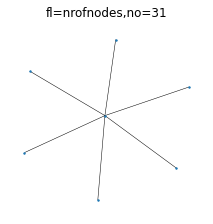

[0, 1, 2, 3, 4, 5, 6]


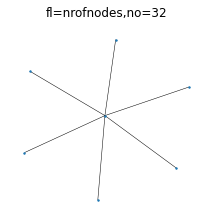

{0: array([-0.22165817,  0.56645577]), 1: array([-0.0618024 ,  0.40728714]), 2: array([-0.18576775,  0.43410461]), 3: array([-0.30775923,  0.47865943]), 4: array([-0.10247518,  0.53346003]), 5: array([-0.15545321,  0.31630487]), 6: array([-0.28026092,  0.3488495 ]), 7: array([-0.96372581, -0.22106066]), 8: array([0.91761578, 0.49576773]), 9: array([0.99816701, 0.04159327]), 10: array([ 0.68201804, -0.54418884]), 11: array([-0.58549356, -0.85837403]), 12: array([-0.10884983, -1.        ]), 13: array([-0.86879991,  0.33305114]), 14: array([0.59263974, 0.65313182]), 15: array([-0.72460924, -0.58998032]), 16: array([ 0.41269656, -0.89296537]), 17: array([ 0.96351808, -0.50209611])}
[0, 1, 2, 3, 4, 5, 6]


<Figure size 1800x1800 with 0 Axes>

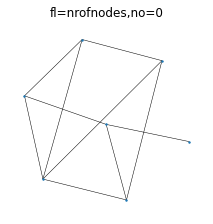

[0, 1, 2, 3, 4, 5, 6]


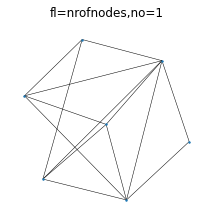

[0, 1, 2, 3, 4, 5, 6]


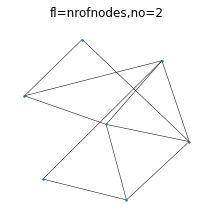

[0, 1, 2, 3, 4, 5, 6]


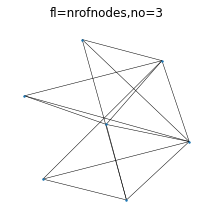

[0, 1, 2, 3, 4, 5, 6]


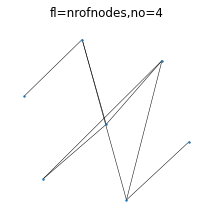

[0, 1, 2, 3, 4, 5, 6]


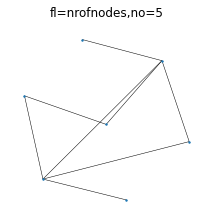

[0, 1, 2, 3, 4, 5, 6]


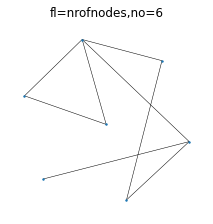

[0, 1, 2, 3, 4, 5, 6]


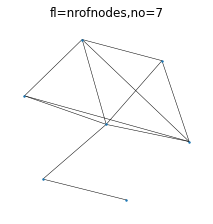

[0, 1, 2, 3, 4, 5, 6]


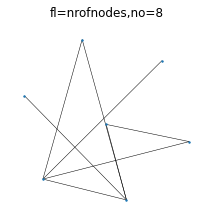

[0, 1, 2, 3, 4, 5, 6]


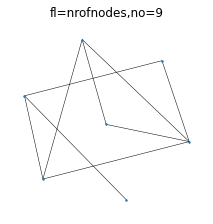

[0, 1, 2, 3, 4, 5, 6]


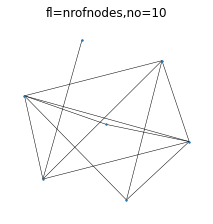

[0, 1, 2, 3, 4, 5, 6]


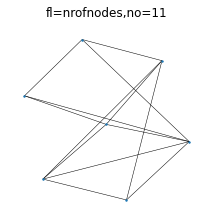

[0, 1, 2, 3, 4, 5, 6]


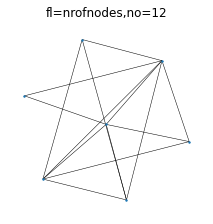

[0, 1, 2, 3, 4, 5, 6]


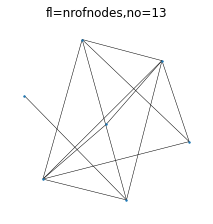

[0, 1, 2, 3, 4, 5, 6]


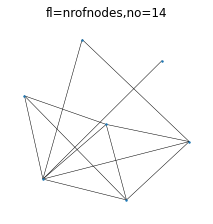

[0, 1, 2, 3, 4, 5, 6]


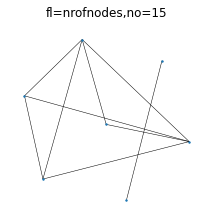

[0, 1, 2, 3, 4, 5, 6]


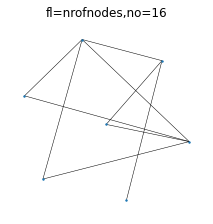

[0, 1, 2, 3, 4, 5, 6]


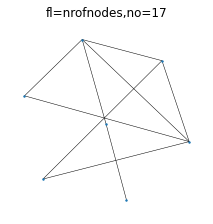

[0, 1, 2, 3, 4, 5, 6]


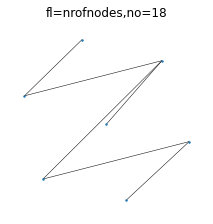

[0, 1, 2, 3, 4, 5, 6]


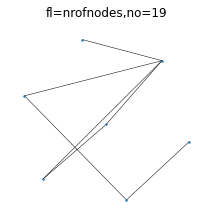

[0, 1, 2, 3, 4, 5, 6]


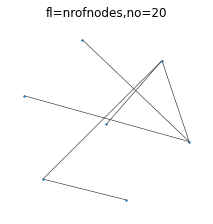

[0, 1, 2, 3, 4, 5, 6]


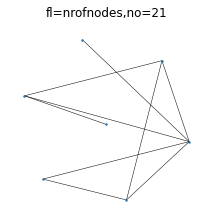

[0, 1, 2, 3, 5, 6]


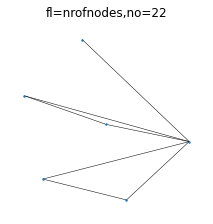

[1, 3, 4, 5, 6]


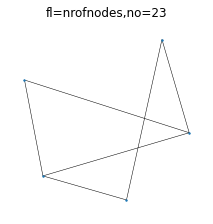

[0, 1, 2, 3, 4, 5, 6]


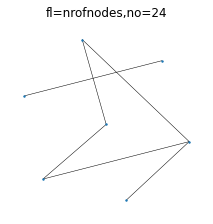

[1, 2, 3, 4, 6]


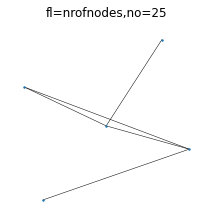

[0, 1, 2, 3, 4, 5]


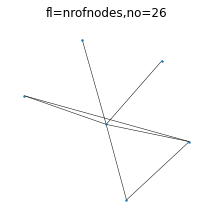

[0, 1, 2, 3, 4, 5, 6]


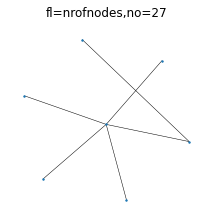

[0, 1, 2, 3, 4, 5, 6]


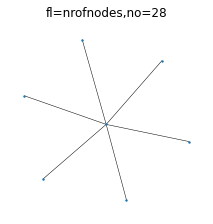

[0, 1, 2, 3, 4, 5, 6]


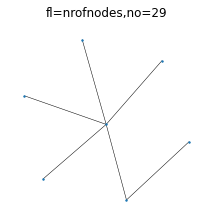

[0, 1, 2, 3, 4, 5, 6]


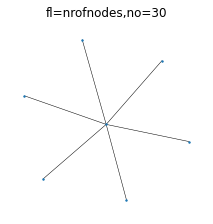

[0, 1, 2, 3, 4, 5, 6]


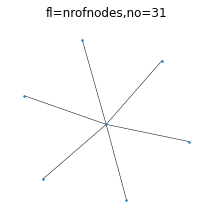

40 32
Time computing degree mmd:  0:00:00.618220
{'degree': 0.04590478740566706}
Time computing clustering mmd:  0:00:06.397815
{'degree': 0.04590478740566706, 'cluster': 0.031851777278742555}
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w
evaluation/orca
e
r
t
i
w

{'degree': 0.04590478740566706,
 'cluster': 0.031851777278742555,
 'orbit': 0.010858211102896753}

In [24]:
#### Here testing is initiated 

## choose the corresponding trainrun and enter the config yaml file path here: (found in directory config/gridsearch/...)
args = Namespace(config_file='config/gridsearch/consec_ppgn_1.7_17:42/gridsearch_ppgn_consec_ego_18_small_8,128_1_64_switched_True_1234.yaml', log_level='INFO', comment='')

ori_config_dict = get_config(args)
config_dict = edict(ori_config_dict.copy())
process_config(config_dict)

## depending on if you trained with ppgn_simple or ppgn_vlb run the correct sample function
## choose the corresponding model you wish to test and enter its path here: (the directory to your model can easily be found in the info page of your wandb or in the .out file of your slurm_logs)
## by using /best or /bestloss or /besloss_eval you may choose the models given by the modelselection instead of the most recent one
## also choose what number of noiselevels you want to use (you may find it good to use more noiselevels for sampling than you did for training as the interval between two noiselevels is still somewhat well defined and informative and also in the ppgn_simple implementation we drew the levels randomly anyway and they werent fixxed on some number
sample_ppgn_simple(config_dict,"exp/gridsearch/ppgn_ego_18_small__Jul-01-17-42-58_155987/models",32)
##sample_ppgn_vlb(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__Jun-03-10-38-49_23391/models",1,32)